In [1]:
import os
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

In [2]:
from collections import defaultdict
from pathlib import Path
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from omegaconf import OmegaConf

from diverse_gen.utils.exp_utils import get_conf_dir
from diverse_gen.utils.proc_data_utils import get_exp_metrics, get_max_acc, get_acc_results


In [28]:
EXP_DIR =  "output/cc_mix_rate/2025-02-17_13-19-36" # "output/cc_mix_rate/2025-02-17_19-36-06"

In [33]:
SEEDS = [1, 2, 3]
MIX_RATES = [0.1, 0.25, 0.5, 0.75, 1.0]
DATASETS = [
    "toy_grid", 
    "fmnist_mnist", 
    "cifar_mnist", 
    "waterbirds", 
    "celebA-0", 
    "multi-nli"
]
METHODS = [
    "TopK_0.1", 
    "TopK_0.5", 
    "TopK_0.1_No_Sched",
    # "TopK_0.5_No_Sched",
    # "DivDis", 
    # "DBAT", 
    # "ERM"
]

In [34]:
def get_results(acc_metric: str, model_selection="val_loss"):
    results = defaultdict(lambda: defaultdict(list))
    for dataset, method in itertools.product(DATASETS, METHODS):
        exp_dirs = []
        mix_rates = MIX_RATES if method != "ERM" else [0.0]
        for mix_rate, seed in itertools.product(mix_rates, SEEDS):
            exp_dirs.append(get_conf_dir((dataset, method, mix_rate, seed), EXP_DIR))
        perf_source_acc = dataset == "toy_grid"
        results[dataset][method] = get_acc_results(
            exp_dirs=exp_dirs, acc_metric=acc_metric, model_selection=model_selection, 
            perf_source_acc=perf_source_acc, verbose=True
        )
    # recusrively convert default dict to dict
    return results

In [35]:
def to_df(results: dict[dict]): 
    # Create a list to store flattened data
    flattened_data = []

    # Iterate through the nested structure
    for dataset, method_dict in results.items():
        for method, mix_rate_dict in method_dict.items():
            for mix_rate, accuracies in mix_rate_dict.items():
                # For each accuracy value in the list
                for acc in accuracies:
                    flattened_data.append({
                        'Dataset': dataset,
                        'Method': method,
                        'Mix_Rate': mix_rate,
                        'Accuracy': acc
                    })

    # Create DataFrame
    df = pd.DataFrame(flattened_data)
    df.sort_values(['Dataset', 'Method', 'Mix_Rate'], inplace=True)
    return df 

In [36]:
model_selection = "val_loss"
acc_results = get_results("test_acc", model_selection)
alt_acc_results = get_results("test_acc_alt", model_selection)
worst_acc_results = get_results("test_worst_acc", model_selection)

In [37]:
acc_df = to_df(acc_results)
alt_acc_df = to_df(alt_acc_results)
worst_acc_df = to_df(worst_acc_results)

In [38]:
FIGSIZE = (3., 2.5)
FONTSIZE = 12
TICK_FONTSIZE = 10

# use standard matplotlib colors
color_map = plt.rcParams['axes.prop_cycle'].by_key()['color']
METHOD_COLORS = {
    "TopK_0.1": color_map[0], 
    "DivDis": color_map[1],
    "TopK_0.5": color_map[2], 
    "TopK_0.1_No_Sched": "#1e3d8f", 
    "TopK_0.5_No_Sched": "#556b2f", 
    "DBAT": color_map[3], 
    "ERM": color_map[4], 
}

DATASET_TITLES = {
    "toy_grid": "Toy Grid",
    "fmnist_mnist": "FMNIST+MNIST",
    "cifar_mnist": "CIFAR+MNIST",
    "waterbirds": "Waterbirds",
    "celebA-0": "CelebA",
    "multi-nli": "MultiNLI"
}

In [39]:
def plot_acc_results_grid(
    df: pd.DataFrame,
    nrows: int = 2,
    ncols: int = 3,
    figsize: tuple[float, float] = (6, 4),
    ylim: tuple[float, float] = (0.5, 1.0),
    fontsize: int = 10,
    tick_fontsize: int = 8,
    legend_fontsize: int = 8,
    xlabel: str = "Mix Rate",
    ylabel: str = "Accuracy",
    dataset_titles: dict[str, str] = {},
    datasets: list[str] = DATASETS, 
    methods: list[str] = METHODS, 
    legend_bbox: tuple[float, float] = (0.5, 1.05), 
    method_linestyle: dict[str, str] = {},
    method_colors: dict[str, str] = METHOD_COLORS,
):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for idx, dataset in enumerate(datasets):  # Using global DATASETS
        ax = axes[idx]
        dataset_data = df[df['Dataset'] == dataset]
        
        for method in methods:  # Using global METHODS
            method_data = dataset_data[dataset_data['Method'] == method]
            
            if method == "ERM":
                # For ERM, calculate mean and std of all results
                mean_acc = method_data['Accuracy'].mean()
                std_acc = method_data['Accuracy'].std()
                means = [mean_acc] * len(MIX_RATES)
                stds = [std_acc] * len(MIX_RATES)
                line_style = '--'
                marker = None
            else:
                # For other methods, group by mix rate
                grouped = method_data.groupby('Mix_Rate')['Accuracy']
                means = []
                stds = []
                for rate in MIX_RATES: 
                    rate_data = grouped.get_group(rate)
                    means.append(rate_data.mean())
                    stds.append(rate_data.std())
                line_style = method_linestyle.get(method, '-')
                marker = 'o'
            
            ax.plot(MIX_RATES, means, label=method, marker=marker, linestyle=line_style, color=method_colors[method])
            ax.fill_between(MIX_RATES, 
                          [m - s for m, s in zip(means, stds)],
                          [m + s for m, s in zip(means, stds)],
                          alpha=0.2, 
                          color=method_colors[method])

        x_labels = [str(mix_rate) for mix_rate in MIX_RATES]
        ax.set_xticks(MIX_RATES)
        ax.set_xticklabels(x_labels, fontsize=tick_fontsize)
        ax.tick_params(axis='both', labelsize=tick_fontsize)
        title = dataset_titles.get(dataset, dataset) if dataset_titles else dataset
        ax.set_title(title, fontsize=fontsize)
        ax.set_ylim(*ylim)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a single legend for the entire figure
    handles, labels = axes[0].get_lines(), [line.get_label() for line in axes[0].get_lines()]
    fig.legend(handles, labels, loc='center', bbox_to_anchor=legend_bbox, ncol=len(methods), fontsize=fontsize)

    fig.supxlabel(xlabel, fontsize=fontsize)
    fig.supylabel(ylabel, fontsize=fontsize)
    
    fig.tight_layout()
    return fig, axes

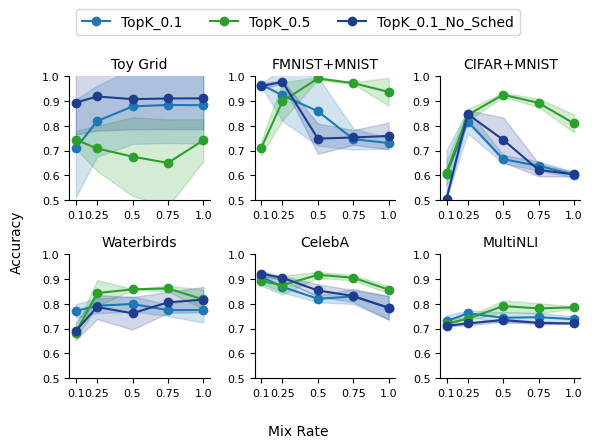

In [40]:
fig, axes = plot_acc_results_grid(
    acc_df, 
    dataset_titles=DATASET_TITLES, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
plt.show()

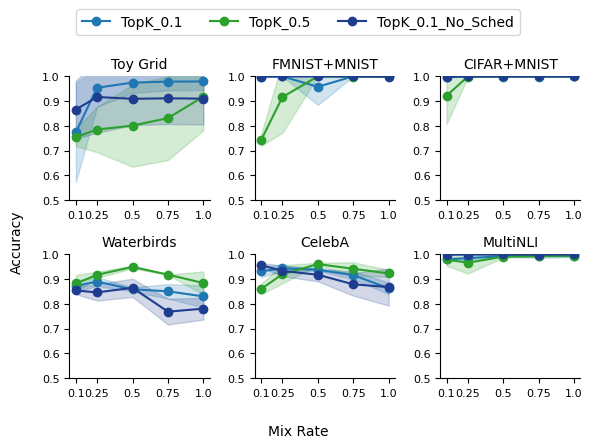

In [41]:
fig, axes = plot_acc_results_grid(
    alt_acc_df, 
    dataset_titles=DATASET_TITLES, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
plt.show()

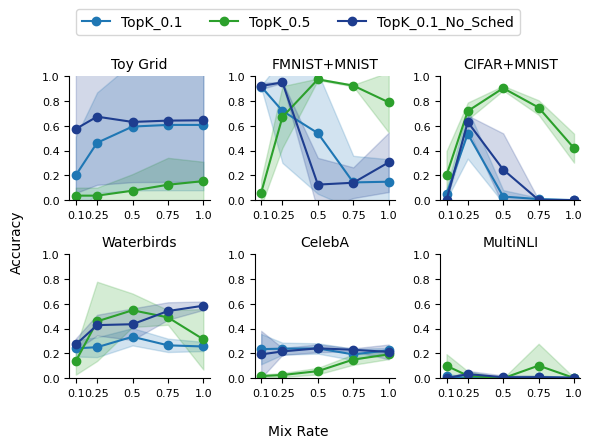

In [44]:
fig, axes = plot_acc_results_grid(
    worst_acc_df, 
    dataset_titles=DATASET_TITLES, 
    ylabel="Accuracy", 
    figsize=(6, 4), 
    ylim=(0.0, 1.0),
    fontsize=10, 
    tick_fontsize=8, 
    legend_fontsize=8, 
    legend_bbox=(0.5, 1.05)
)
plt.show()